In [1]:
#在(https://tw511.com/a/01/27245.html)上學習建構LSTM 
#(tang.npz) https://yun.sfo2.digitaloceanspaces.com/pytorch_book/pytorch_book/tang.npz
import numpy as np     
import os
import time
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchnet import meter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [2]:
def get_data(path):
    
    assert path.is_file()
    
    datas = np.load(path, allow_pickle=True)  
    input = datas['data']  
    word2ix = datas['word2ix'].item()   
    ix2word = datas['ix2word'].item()  
    
    return input, word2ix, ix2word

class LMDataLoader(data.DataLoader):
    
    def __init__(self, data, batch_size):
        self.batch_size = batch_size
        self.bptt = data.size(1)
        self.data = (data.long()
                         .transpose(0,1)
                         .contiguous())
    
    def get_batch(self,idx):
        src = self.data[:-1,idx:idx+self.batch_size]
        tgt = self.data[1:,idx:idx+self.batch_size]
        return src, tgt
    
    def get_fixed_iter(self):
        for idx in range(0, self.data.size(1)-self.batch_size+1,self.batch_size):
            yield self.get_batch(idx)

    def __iter__(self):
        return self.get_fixed_iter()
    
    def __len__(self):
        return self.data.size(1) // self.batch_size
    
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Net, self).__init__()
        # lstm輸入為：seq, batch, input_size
        # lstm輸出為：seq * batch * 256; (2 * batch * 256,...)
        
        self.hidden_dim = hidden_dim
        self.num_layers =  num_layers
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=self.num_layers, batch_first=False)

        self.linear1 = nn.Linear(self.hidden_dim, vocab_size)

    def forward(self, input, hidden=None):
        #Embedding layer (seq_len, batch_size, embedding_dim), (124,128,128)
        #LSTM (seq_len, batch_size, hidden_dim), (124,128,256)
        #Linear ((seq_len * batch_size),hidden_dim), (15872,256) → (15872,8293)
        
        seq_len, batch_size = input.size()
        
        if hidden is None:
            h_0 = input.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
            h_0, c_0 = Variable(h_0), Variable(c_0)
        else:
            h_0, c_0 = hidden
        
        embeds = self.embeddings(input)    
        output, hidden = self.lstm(embeds, (h_0, c_0))      
        output = self.linear1(output.view(seq_len*batch_size, -1))      
        
        return output, hidden

def generate(model, start_words, ix2word, word2ix):     
    txt = []
    for word in start_words:
        txt.append(word)
    input = Variable(torch.Tensor([word2ix['<START>']]).view(1,1).long())      
    input = input.cuda()
    hidden = None
    num = len(txt)
    for i in range(48):      
        output, hidden = model(input, hidden)
        if i < num:
            w = txt[i]
            input = Variable(input.data.new([word2ix[w]])).view(1, 1)
        else:
            top_index = temperature_sampling(output.view(-1),1.4)
            w = ix2word[top_index.item()]
            txt.append(w)
            input = Variable(input.data.new([top_index])).view(1, 1)
        if w == '<EOP>':
            break
    return ''.join(txt)

def temperature_sampling(logits, temperature, topk = 5):
    #sampling method form (N. Keskar, B. McCann, L. R. Varshney, C. Xiong, and R. Socher, “Ctrl: A conditional transformer language model for controllable generation,” ArXiv, vol. abs/1909.05858, 2019)  
    
    temp = torch.tensor([temperature])
    logits=logits.cpu()
    probs = torch.exp(logits / temp) / torch.sum(torch.exp(logits / temp))
    
    if topk == 1:
        prediction = torch.argmax(probs)
    else:
        sorted_index = torch.argsort(probs, descending = True)
        candi_index = sorted_index[:topk]
        candi_index = sorted_index[:topk]
        candi_probs = torch.tensor([probs[i] for i in candi_index])
        # normalize probs
        candi_probs /= torch.sum(candi_probs)
        candi_probs = candi_probs.numpy()
        # choose by predicted probs
        prediction = np.random.choice(candi_index, size=1, p=candi_probs)[0]

    return prediction


In [3]:
data_path = './tang.npz'
data_path = Path(data_path)
assert data_path.is_file()
dataset, word2ix, ix2word = get_data(data_path)

dataset = torch.from_numpy(dataset)


traindata, valdata = train_test_split(dataset, test_size = 0.1, random_state = 1111)

BatchSize = 64
trainLoader = LMDataLoader(traindata, BatchSize)  
validLoader = LMDataLoader(valdata, BatchSize)

In [4]:
# Parameters
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')

model = Net(len(word2ix), 128, 256,2).to(device) 
print(model)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)#train loss
criterion1 = nn.CrossEntropyLoss()#valid loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)

cuda:0 is available!

Net(
  (embeddings): Embedding(8293, 128)
  (lstm): LSTM(128, 256, num_layers=2)
  (linear1): Linear(in_features=256, out_features=8293, bias=True)
)


床前明月光，明镜照镜镜，君不同。不见君人不见，此时如何。不知不知，不知何事无一。。有时无语皆不知
Early stopping!

Finished Training


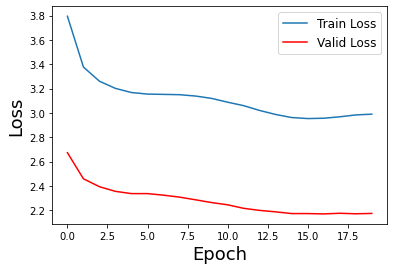

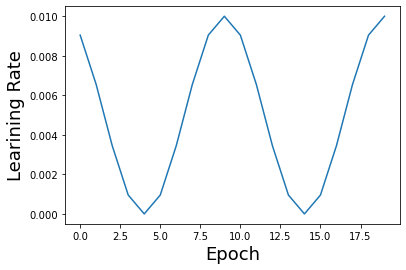

In [5]:
#store loss function (meter.AverageValueMeter())  
#loss_meter.reset() reset 
#loss_meter.add(val) add value
#loss_meter.value() get (mean, std)
loss_meter = meter.AverageValueMeter()
loss_dic={'train_loss':[], 'valid_loss':[], 'lr':[]}

#early_stopping
patience=3
earlystop=0
best_loss=float('inf')

epochs = 50

for epoch in range(epochs):
    #Training
    model.train()
    loss_meter.reset()
    with tqdm(trainLoader) as tepoch:
        for src, tgt in tepoch:
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            
            src, tgt = src.to(device), tgt.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            output,_ = model(src)
            
            #one hot target
            tgt=F.one_hot(tgt.view(-1),len(word2ix))
            tgt=tgt.type_as(output)
            crit=criterion(output,tgt)
            loss_meter.add(crit.item())
            
            crit.backward()
            optimizer.step()

            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    
    scheduler.step()
    loss_dic['train_loss'].append(loss_meter.value()[0])
    
    #Validating
    model.eval()
    loss_meter.reset()
    with tqdm(validLoader) as tepoch:
        for src, tgt in tepoch:
            tepoch.set_description(f'ValidEpoch{epoch+1:3d}')
            
            src, tgt = src.to(device), tgt.to(device)
            output,_ = model(src)
            
            #one hot target
            tgt=F.one_hot(tgt.view(-1),len(word2ix))
            tgt=tgt.type_as(output)
            crit=criterion1(output,tgt)
            loss_meter.add(crit.item())
            
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    
    loss_dic['valid_loss'].append(loss_meter.value()[0])
    loss_dic['lr'].append(scheduler.get_last_lr())
    
    clear_output(wait=True)    
    print(generate(model,'床前明月光，', ix2word, word2ix))
    time.sleep(0.5)
    
    # earlystopping
    cur_loss = loss_meter.value()[0]
    if cur_loss>best_loss:
        earlystop+=1
        if earlystop>= patience:
            print('Early stopping!\n')
            break
    else:
        earlystop=0
        best_loss=cur_loss
    
print('Finished Training')

#plot training loss and valid loss

plt.plot(loss_dic['train_loss'])
plt.plot(loss_dic['valid_loss'],color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
plt.show()

#plot lr

plt.plot(loss_dic['lr'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Learining Rate', fontsize=18)
plt.show()

In [6]:
print(loss_dic['train_loss'][-1])

2.989763521882894
